Name : Dhyan Navneeth V
Class : S6 ECE
Roll no : 25


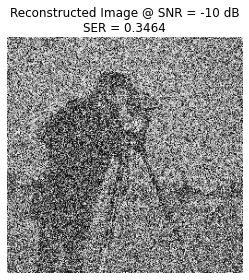

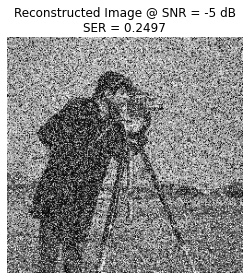

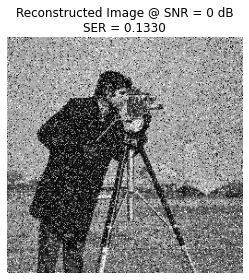

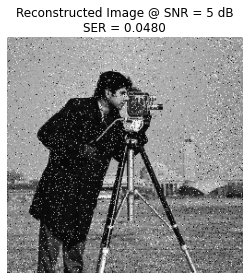

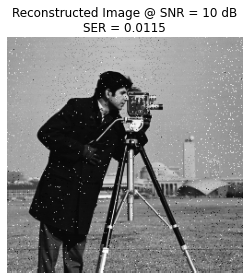

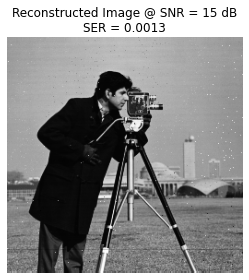

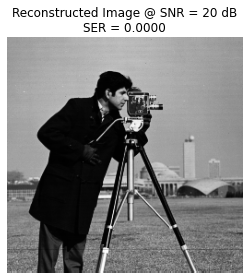

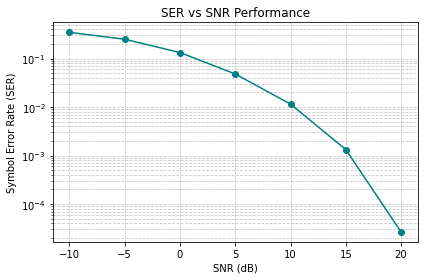

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve

print("Name : Dhyan Navneeth V")
print("Class : S6 ECE")
print("Roll no : 25")

# ------------------ SRRC Pulse Generator ------------------
def generate_srrc_pulse(Tsym, beta, L, Nsym):
    t = np.arange(-Nsym/2, Nsym/2, 1/L)
    p = np.zeros_like(t)

    for i, ti in enumerate(t):
        if ti == 0:
            p[i] = (1 - beta + 4 * beta / np.pi) / np.sqrt(Tsym)
        elif abs(ti) == Tsym / (4 * beta):
            p[i] = (beta / np.sqrt(2 * Tsym)) * ((1 + 2/np.pi) * np.sin(np.pi/(4 * beta)) + (1 - 2/np.pi) * np.cos(np.pi/(4 * beta)))
        else:
            num = (np.sin(np.pi * ti * (1 - beta) / Tsym) + 4 * beta * ti / Tsym * np.cos(np.pi * ti * (1 + beta) / Tsym))
            denom = (np.pi * ti / Tsym) * (1 - (4 * beta * ti / Tsym) ** 2)
            p[i] = num / denom

    # Normalize pulse energy
    return p / np.sqrt(np.sum(p ** 2))

# ------------------ Upsampling and Filtering ------------------
def upsample_and_filter(symbols, pulse, L):
    upsampled = np.zeros(len(symbols) * L)
    upsampled[::L] = symbols
    return convolve(upsampled, pulse, mode='full')

# ------------------ AWGN Channel ------------------
def add_awgn(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    noise_power = 1 / (2 * snr_linear)
    noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    return signal + noise

# ------------------ Matched Filtering and Demodulation ------------------
def matched_filter_and_demodulate(received, pulse, L, num_bits):
    matched_output = convolve(received, pulse, mode='full')
    delay = (len(pulse) - 1) // 2
    sampled = matched_output[2 * delay + 1::L]
    detected = np.where(sampled >= 0, 1, -1)
    return detected[:num_bits]

# ------------------ Simulation ------------------
def simulate():
    # Load image
    image = cv2.imread(r"G:\My Drive\KTU\S6\Comm LAB\cameraman.png", cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Image not found.")
    
    bits = np.unpackbits(image.flatten())
    symbols = np.where(bits == 0, -1, 1)

    # Parameters
    Tsym, beta, L, Nsym = 1, 0.3, 4, 8
    pulse = generate_srrc_pulse(Tsym, beta, L, Nsym)
    tx_signal = upsample_and_filter(symbols, pulse, L)

    snr_range = np.arange(-10, 21, 5)
    ser_list = []

    # ------------------ Loop over SNR ------------------
    for snr in snr_range:
        rx_signal = add_awgn(tx_signal, snr)
        detected = matched_filter_and_demodulate(rx_signal, pulse, L, len(bits))

        # SER Calculation
        ser = np.sum(symbols != detected) / len(symbols)
        ser_list.append(ser)

        # Reconstruct Image
        recovered_bits = (detected == 1).astype(np.uint8)
        recovered_bits = np.pad(recovered_bits, (0, 8 - len(recovered_bits) % 8), mode='constant')[:len(bits)]
        recovered_image = np.packbits(recovered_bits).reshape(image.shape)

        # ------------------ Show Reconstructed Image ------------------
        plt.figure(figsize=(4, 4))
        plt.imshow(recovered_image, cmap='gray')
        plt.title(f'Reconstructed Image @ SNR = {snr} dB\nSER = {ser:.4f}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # ------------------ SER vs SNR Plot ------------------
    plt.figure(figsize=(6, 4))
    plt.semilogy(snr_range, ser_list, marker='o', linestyle='-', color='teal')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Symbol Error Rate (SER)')
    plt.title('SER vs SNR Performance')
    plt.tight_layout()
    plt.show()

simulate()
